In [4]:
Pkg.add("Distances")

 Resolving package versions...
 Installed StatsAPI ── v1.0.0
 Installed Distances ─ v0.10.3
  Updating `C:\Users\ASUS\OneDrive\Documentos\MIT MBAn\Spring\Robust\Software\15094code\Project.toml`
  [b4f34e82] + Distances v0.10.3
  Updating `C:\Users\ASUS\OneDrive\Documentos\MIT MBAn\Spring\Robust\Software\15094code\Manifest.toml`
  [b4f34e82] + Distances v0.10.3
  [82ae8749] + StatsAPI v1.0.0


In [2]:
using Pkg
Pkg.add("StatsBase")

  Updating registry at `C:\Users\ASUS\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  99.9 %0.0 %===>                                     ]  6.6 %]  20.5 % [=========>                               ]  22.4 %33.7 % [====================>                    ]  48.5 % [========================>                ]  58.0 %.8 %====================================>    ]  89.3 %1 %95.5 % Resolving package versions...
 Installed Grisu ─────────────── v1.0.2
 Installed FillArrays ────────── v0.11.7
 Installed Conda ─────────────── v1.5.2
 Installed Parsers ───────────── v1.1.0
 Installed ColorTypes ────────── v0.10.12
 Installed Colors ────────────── v0.12.8
 Installed StaticArrays ──────── v1.1.2
 Installed StatsFuns ─────────── v0.9.8
 Installed LogExpFunctions ───── v0.2.3
 Installed DocStringExtensions ─ v0.8.4
 Installed BenchmarkTools ────── v0.7.0
 Installed MutableArithmetics ── v0.2.19
 

In [5]:
using JuMP, JuMPeR, Gurobi, Random, StatsBase, Distributions, LinearAlgebra, DataFrames, Plots, Distances

┌ Info: Recompiling stale cache file C:\Users\ASUS\.julia\compiled\v1.0\Distances\yuMjt.ji for Distances [b4f34e82-e78d-54a5-968a-f98e89d6e8f7]
└ @ Base loading.jl:1190


# Process for generating synthetic data

Our supply and demand models time-dependent (can also be product dependent) are given by:
- Supply: $S_{t} =  (s_{t}+z_{t})p_{t} $ 
- Demand: $D_{t} = \alpha_{t} + \beta_{t}*p_{t}$

And the model which we are trying to maximize (profit) given that supply is greater than demand is given by:
$$\pi(p, z) = \sum_{t=1}^{T} D_{t}p_{t} - c_{t}D_{t} - \delta_{t}v_{t}$$ 

In the above we have
- Decision variables: $p_{t}$ (price at time $t$)
- Uncertain variables: $z_{t}$ (perturbation on the supply) 

The data is given by:
- $\alpha_{t}$: price-insensitive demand at time $t$
- $\beta_{t}$: slope of demand curve at time $t$ 
- $s_{t}$: slope of supply curve at time $t$ 
- $c_{t}$: cost (to the company) of a ride at time $t$, where the wage changes throughout the day
- $\delta_{t}$: the cost of unfulfilled drivers at time $t$ (to keep your drivers engaged)

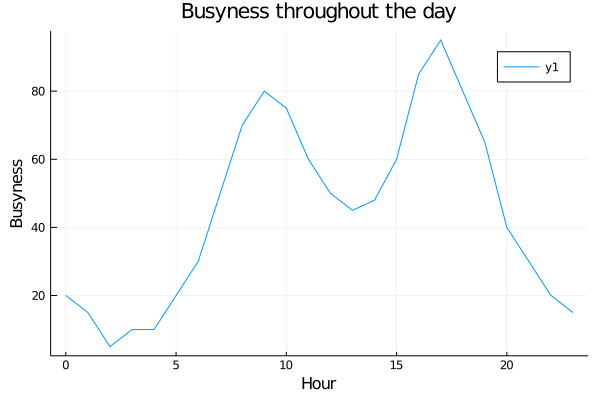

In [237]:
busyness_t = [20,15,5,10,10,20,30,50,70,80,75,60,50,45,48,60,85,95,80,65,40,30,20,15] # latent metric of busyness throughout the day from 0 to 100, starting at 00:00 (12 AM)
n_periods = length(busyness_t)
t = [i for i in range(0,stop =n_periods-1)]
plot(t,busyness_t,title="Busyness throughout the day", xlabel ="Hour",ylabel = "Busyness" )

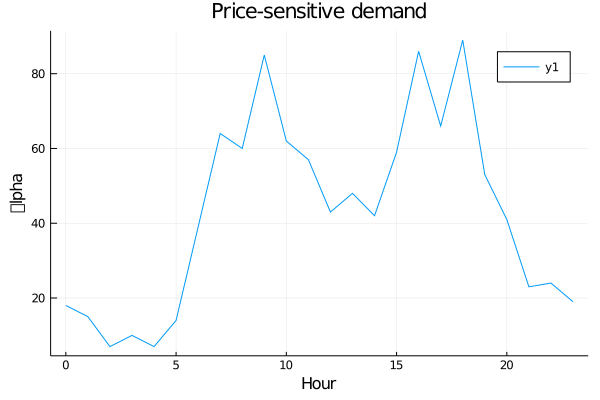

In [238]:
Random.seed!(MersenneTwister(15094)); # we simulate data for 24 hours (hourly timestep)
α = [rand(Poisson(x)) for x in busyness_t]
plot(t,α,title="Price-sensitive demand", xlabel ="Hour",ylabel = "\alpha" )

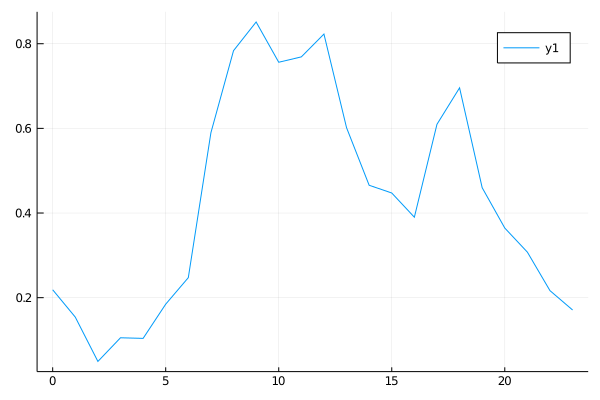

In [239]:

"""
Demand β ∈ [0,10]:
- Smaller β means that consumers are price insensitive (you change price, they don't change quantity of demand)
- Opposite for larger β
- Therefore expect slope to roughly follow busyness because at late hours, people will pay whatever price for a ride home
- In the early hours with lots of drivers, they can afford to take the subway/bus/other transportation
- The difference is that there is more sensitivity in the morning and less at night (if you drove to work, you drive back)
"""
β_t = [20,15,5,10,10,20,30,60,80,90,75,70,70,60,50,50,45,55,60,45,40,30,20,15]
β = [rand(Normal(x/100, x/1000)) for x in β_t]
θ=β/10
plot(t,β)

In [240]:
# plot actual demand throughout the day for different fixed price policies 
prices = [10,20,30,40,60,80,100]
D = zeros(n_periods,length(prices))
for i in range(1, stop = length(prices))
    p = prices[i]
    demand_t = [α[t]-β[t]*p for t in range(1,stop=n_periods)]
    demand_t = [if d>=0 d else 0 end for d in demand_t] # demand can never be negative
    D[:,i] = demand_t
end

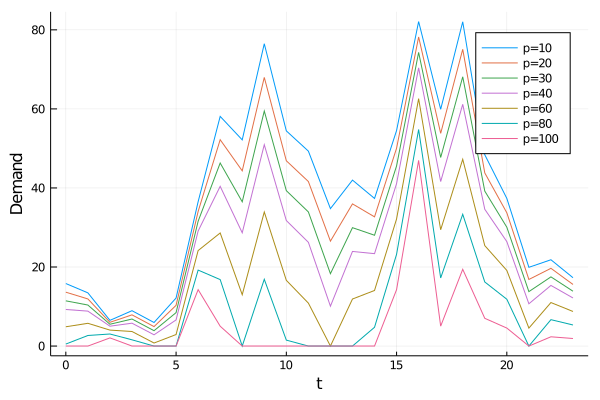

In [241]:
plot(t,D, label = ["p=10" "p=20" "p=30" "p=40" "p=60" "p=80" "p=100"],xlabel = "t", ylabel ="Demand")

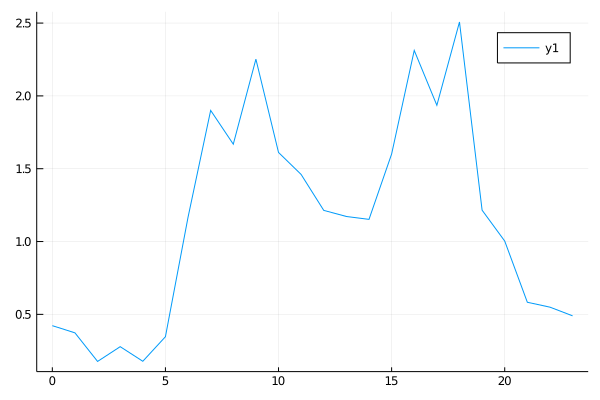

In [242]:
"""
Supply
- When simulating supply slope, we consider the number of active drivers at any time. 
- This is also generally correlated with business
- The only difference is that drivers are more active throughout the evening as well 
"""

s_t = [30,20,20,10,5,30,50,80,90,95,85,75,70,70,65,50,50,55,70,80,75,65,55,45]
#s_t=α.*2.5
s = [rand(Normal(x/100, x/1000)) for x in s_t] 
plot(t,s)


In [243]:
"""
Constants 
- c_t: wages for drivers as a percentage, we can assume that we pay a relatively stable proportion and a little bit more at peak hours  
- δ_t: driver keeping costs, generally higher in the day and lower at night
"""

c = [0.7,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.7,0.7,0.8,0.8,0.7,0.6,0.6,0.8,0.7,0.6,0.6,0.6,0.6,0.7,0.7];
δ = [ 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];

# Solve the nominal problem

$$\pi(p, z) = \sum_{t=1}^{T} D_{t}p_{t} - c_{t}D_{t} + \delta_{t}v_{t}$$ 

In [22]:
m = Model(solver = GurobiSolver(OutputFlag=1))
@variable(m, p[1:n_periods] >= 0)
@variable(m, v[1:n_periods] >= 0)
@constraint(m, [t=1:n_periods], v[t] == s[t]*p[t] - (α[t]-β[t]*p[t])) # S > D at all periods
@constraint(m, [t=1:n_periods], v[t] >= 0)
@objective(m, Max, sum([(α[t]-β[t]*p[t])*(p[t]-c[t]) - δ[t]*v[t] for t=1:n_periods]));

In [295]:
#This comes from: rides*p-rides*salary=rides*(p-salary)=rides*(p-c*p)=rides*p(1-c) 
r=-c.+1
;

In [296]:
m = Model(solver = GurobiSolver(OutputFlag=1))
@variable(m, p[1:n_periods] >= 0)
@variable(m, τ)

@constraint(m,
    sum(p[t]*p[t]*r[t]*β[t]+p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=1:n_periods)+τ<=0)
@constraint(m, [t=1:n_periods], s[t]*p[t]>=α[t]-β[t]*p[t])

@objective(m, Max, τ);

In [297]:
solve(m)

Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 24 rows, 25 columns and 24 nonzeros
Model fingerprint: 0xab3ef900
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  QMatrix range    [2e-02, 3e-01]
  QLMatrix range   [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 9e+01]
  QRHS range       [3e+03, 3e+03]
Presolve removed 24 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.00 seconds
Optimal objective 8.04784105e+03


:Optimal

In [23]:
salary= ct
but now salary=ct*pt
solve(m)

Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 48 rows, 48 columns and 72 nonzeros
Model fingerprint: 0x308738a0
Model has 24 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-01, 2e+00]
  Objective range  [1e+00, 9e+01]
  QObjective range [9e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+01]
Presolve removed 48 rows and 48 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.02 seconds
Optimal objective 3.14715809e+04


:Optimal

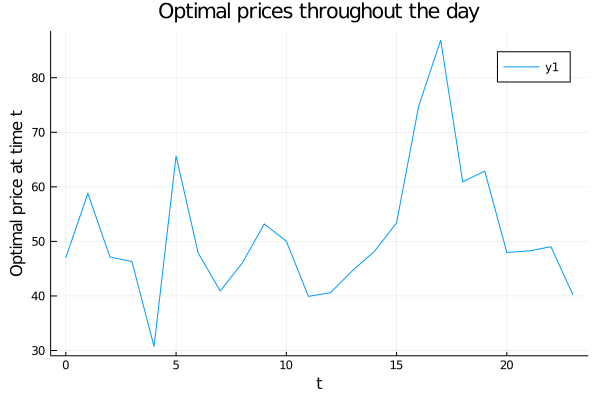

In [186]:
plot(t,getvalue.(p), xlabel = "t", ylabel="Optimal price at time t", title = "Optimal prices throughout the day")

# Simulate uncertainty set 

When simulating, note that there is a difference between defining the robustness SET and the respective probability DISTRIBUTION. The set is only defined by the boundaries (ellipsoidal, box, budget) while the distribution defines which points in that set are more likely to draw. 

For our purposes, I'll just be doing rejection sampling using a uniform/gaussian distribution, so all uncertainties are centered in the respective sets. 

In [25]:
# box
function generate_z_box(l,n,p)
    """
    Inputs:
    l: the shape of the box 
    n: number of samples
    p: dimension of samples
    
    Returns:
    n x p Matrix of samples 
    """
    return rand(Uniform(-l/2,l/2),n,p)
end

# ellipsoidal 
function generate_z_ellipse(ρ,n,p)
    """
    Inputs:
    ρ: size of l2 norm
    n: number of samples
    p: dimension of samples
    
    Returns:
    n x p Matrix of samples 
    """
    n_samples = 1
    v = zeros(n,p)
    while n_samples < n+1
        x = rand(Normal(0,1),p)
        if norm(x,2) <= ρ
            v[n_samples,:] = x
            n_samples += 1
        end
    end
    return v
end

# Budget
function generate_z_budget(ρ, γ, n, p)
    """
    At most γ (integer) elements are ρ away from their nominal values 
    """
    n_samples = 1
    v = zeros(n,p)
    while n_samples < n+1
        x = rand(Uniform(-γ,γ),p)
        if (norm(x,Inf) <= ρ) & (norm(x,1) <= γ)
            v[n_samples,:] = x
            n_samples += 1
        end
    end
    return v
end
    

generate_z_budget (generic function with 1 method)

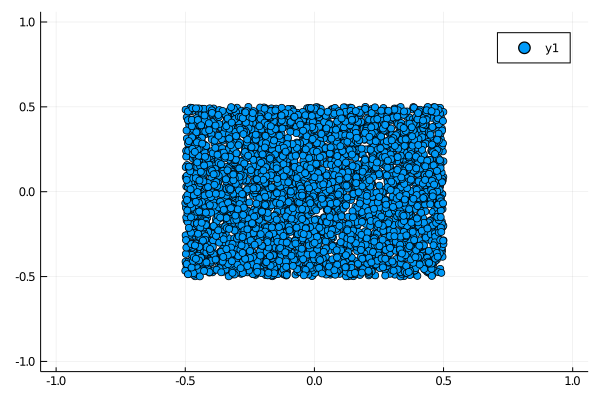

In [26]:
z = generate_z_box(1,4000,2)
scatter(z[:,1], z[:,2], xlim=[-1,1], ylim=[-1,1])

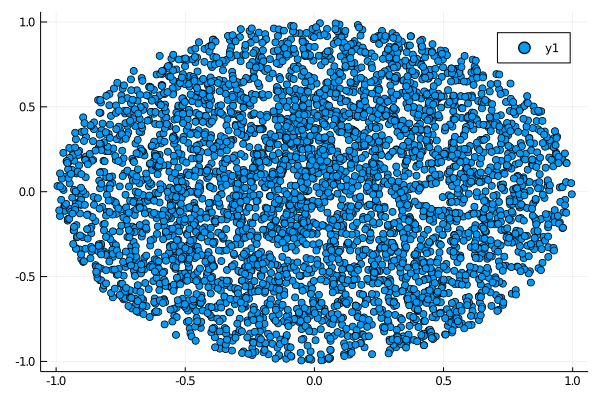

In [27]:
z = generate_z_ellipse(1,4000,2)
scatter(z[:,1], z[:,2], xlim=[-1,1], ylim=[-1,1])

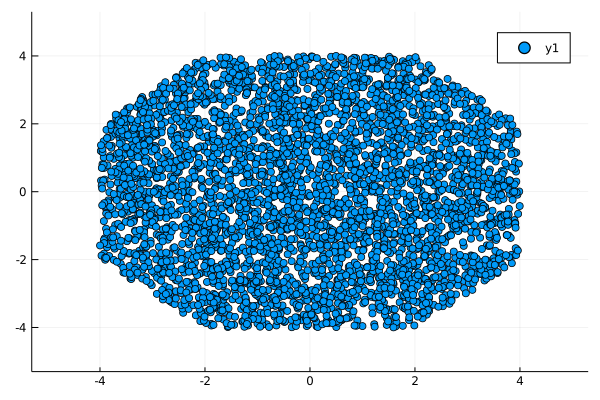

In [28]:
z = generate_z_budget(4,6,4000,2)
scatter(z[:,1], z[:,2], xlim=[-5,5], ylim=[-5,5])

# Next up: Set up robust problem and test profits between robust vs. nominal prices solved above

We are going to solve the robust problems for the following levels of confidences! 

In [443]:
unc_range=[75, 85, 90,95, 97, 99]./100
ϵ=-unc_range.+1
;

### Robust Problem with Box Uncertainty Set

The $\rho$ in the box (and budget) uncertainty set is 1. This is to use the Theorem 3.2

In [338]:
function optimize_box(ρ)
    m = Model(solver = GurobiSolver(OutputFlag=1))
    @variable(m, p[1:n_periods] >= 0)
    @variable(m, v[1:n_periods]>=0) #it will never be negative
    @variable(m, τ)


    @constraint(m,
        sum(p[t]*p[t]*r[t]*β[t]+p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=1:n_periods)+τ+
        ρ*sum(v)<=0)

    @constraint(m, [t=1:n_periods], θ[t]*r[t]*p[t]*p[t]+θ[t]*p[t]<=v[t])


    #robust counterpart
    @constraint(m, [t=1:n_periods], -(s[t]+β[t])*p[t]+α[t]+
        ρ*p[t]*θ[t]<=0)

    @objective(m, Max, τ);
    
    solve(m)
    
    IJulia.clear_output()
    
    pval=JuMP.getvalue(p);
    obj_func=JuMP.getobjectivevalue(m)
    return pval, obj_func
end

optimize_box (generic function with 1 method)

In [346]:
ρ=1;

In [347]:
pval, obj_func=optimize_box(ρ);

In [348]:
obj_func

7556.707908281394

In [328]:
pval=JuMP.getvalue(p);

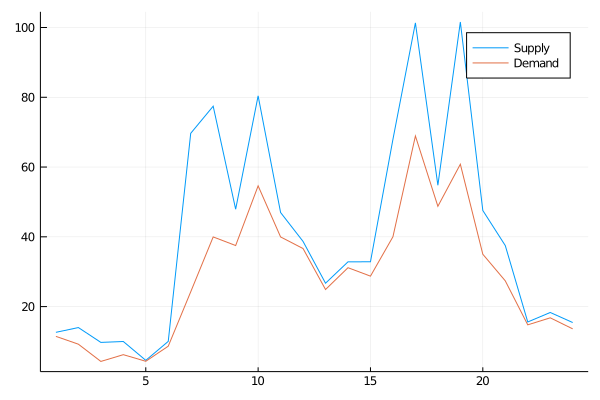

In [349]:
plot(s.*pval, label="Supply")
plot!(α.-pval.*β, label="Demand")

### Robust Problem with Ellipsoidal Uncertainty Set

In [408]:
function optimize_ellipsoid(ρ)
    m = Model(solver = GurobiSolver(OutputFlag=1))
    @variable(m, p[1:n_periods] >= 0)
    @variable(m, v[1:n_periods]>=0) #it will never be negative
    @variable(m, τ)


    @constraint(m,
        sum(p[t]*p[t]*r[t]*β[t]+p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=1:n_periods)+τ+
        ρ*sqrt(sum(v[t]*v[t] for t=1:n_periods))<=0)

    @constraint(m, [t=1:n_periods], θ[t]*r[t]*p[t]*p[t]+θ[t]*p[t]<=v[t])


    #robust counterpart
    @constraint(m, [t=1:n_periods], -(s[t]+β[t])*p[t]+α[t]+
        ρ*sqrt(p[t]*θ[t]*p[t]*θ[t])<=0)

    @objective(m, Max, τ);
    
    solve(m)
    
    #IJulia.clear_output()
    
    pval=JuMP.getvalue(p);
    obj_func=JuMP.getobjectivevalue(m)
    return pval, obj_func
end

optimize_ellipsoid (generic function with 1 method)

In [394]:
#Based on the previous levels of errors that we want to be robust against!
ρ_range=sqrt.(2*log.(1 ./ϵ));

6-element Array{Float64,1}:
 1.6651092223153954
 1.9478808920906234
 2.145966026289347 
 2.447746830680816 
 2.6482288033023056
 3.0348542587702925

In [409]:
pval, obj_func=optimize_ellipsoid(1.66);

ErrorException: sqrt is not defined for type QuadExpr. Are you trying to build a nonlinear problem? Make sure you use @NLconstraint/@NLobjective.

In [401]:
obj_func_ellipsoid=[]
prices_ellipsoid=[]
for Γ in Γ_range
    pval, obj_func=optimize_ellipsoid(ρ)
    append!(obj_func_ellipsoid, obj_func)
    append!(prices_ellipsoid, [pval])
end

Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 0 rows, 49 columns and 0 nonzeros
Model fingerprint: 0xd40677fe
Model has 49 quadratic constraints
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [4e-05, 2e+00]
  QLMatrix range   [5e-03, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [7e+00, 3e+03]
Presolve time: 0.00s
Presolved: 194 rows, 195 columns, 388 nonzeros
Presolved model has 49 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 Free vars  : 1
 AA' NZ     : 6.270e+02
 Factor NZ  : 1.262e+03
 Factor Ops : 9.246e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.91975128e-02 -0.00000000e+00  1.68e+02 6.40e+01  4.81e+00    

In [ ]:
obj_func_ellipsoid

In [ ]:
prices_ellipsoid

In [ ]:
plot(prices_ellipsoid)

### Robust Problem with Budget Uncertainty Set

In [410]:
ρ=1
Γ_range= sqrt.(2*log.(1 ./ϵ))*sqrt(n_periods);

In [422]:
function optimize_budget(ρ, Γ)
    m = Model(solver = GurobiSolver(OutputFlag=1))
    @variable(m, p[1:n_periods] >= 0)
    @variable(m, v[1:n_periods]>=0) #it will never be negative
    @variable(m, τ)
    @variable(m, y[1:n_periods])
    @variable(m, y_abs[1:n_periods]>=0)
    @variable(m, inf_norm)
    


    @constraint(m,
        sum(p[t]*p[t]*r[t]*β[t]+p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=1:n_periods)+τ+
        ρ*sum(y_abs)+Γ*inf_norm<=0)
    
    #These are some auxiliary constraints to find the conjugate of v|Z. This involves calculating the inf
    #norm of v-y
    @constraint(m, [t=1:n_periods],v[t]-y[t]<=inf_norm)
    @constraint(m, [t=1:n_periods],-v[t]+y[t]<=inf_norm)
    
    @constraint(m, [t=1:n_periods], y[t]<=y_abs[t])
    @constraint(m, [t=1:n_periods], -y[t]<=y_abs[t])

    @constraint(m, [t=1:n_periods], θ[t]*r[t]*p[t]*p[t]+θ[t]*p[t]<=v[t])


    #robust counterpart of the supply>=demand constraint
    @variable(m, y2[1:n_periods])
    @variable(m, y2_abs[1:n_periods]>=0)
    @variable(m, inf_norm2[1:n_periods])
    @constraint(m, [t=1:n_periods], -(s[t]+β[t])*p[t]+α[t]+
        ρ*y2_abs[t]+Γ*inf_norm2[t]<=0)#ρ*p[t]*θ[t]<=0)
    @constraint(m, [t=1:n_periods], y2[t]<=y2_abs[t])
    @constraint(m, [t=1:n_periods], -y2[t]<=y2_abs[t])
    
    @constraint(m, [t=1:n_periods], -θ[t]*p[t]-y2[t]<=inf_norm2[t])
    @constraint(m, [t=1:n_periods], +θ[t]*p[t]+y2[t]<=inf_norm2[t])
    
    
    
    
    @objective(m, Max, τ);
    
    solve(m)
    
    IJulia.clear_output()
    
    pval=JuMP.getvalue(p);
    obj_func=JuMP.getobjectivevalue(m)
    return pval, obj_func
end

optimize_budget (generic function with 2 methods)

In [439]:
obj_func_budget=[]
prices_budget=[]
for Γ in Γ_range
    pval, obj_func=optimize_budget(ρ, Γ)
    append!(obj_func_budget, obj_func)
    append!(prices_budget, [pval])
end

In [440]:
obj_func_budget

6-element Array{Any,1}:
 7734.407223501172 
 7704.8301624705255
 7686.696533654617 
 7661.14180616481  
 7645.567706369753 
 7623.3680979691   

In [441]:
prices_budget

6-element Array{Any,1}:
 [33.0539, 41.3801, 60.7035, 39.6481, 28.1772, 31.9662, 59.7077, 40.7525, 28.7162, 35.6991  …  31.481, 42.4374, 48.4526, 31.2999, 40.5104, 39.1281, 38.7919, 26.7494, 36.835, 34.8219] 
 [33.054, 41.3802, 60.7037, 39.6482, 28.1774, 31.9664, 59.7137, 40.7539, 28.7142, 35.695  …  30.9502, 42.431, 47.2728, 30.8451, 40.5093, 39.1237, 37.366, 26.7494, 36.8351, 34.8221]   
 [33.054, 41.3802, 60.7037, 39.6482, 28.1774, 31.9663, 59.7032, 40.755, 28.7192, 35.7019  …  29.9557, 42.4407, 45.7371, 29.8421, 40.5106, 39.1317, 37.3642, 26.7494, 36.8351, 34.822]  
 [33.054, 41.3803, 60.7037, 39.6483, 28.1774, 31.9664, 59.7069, 40.753, 28.7169, 35.7  …  28.5044, 42.438, 43.8201, 28.3259, 40.5113, 39.1287, 37.3712, 26.7495, 36.8351, 34.8221]     
 [33.054, 41.3803, 60.7037, 39.6482, 28.1774, 31.9664, 59.7076, 40.7522, 28.717, 35.6996  …  28.5045, 42.4371, 43.8198, 28.3035, 40.5095, 39.1284, 37.37, 26.7494, 36.8351, 34.8221]   
 [33.054, 38.6016, 60.7037, 39.6482, 28.1774, 31.9664, 5

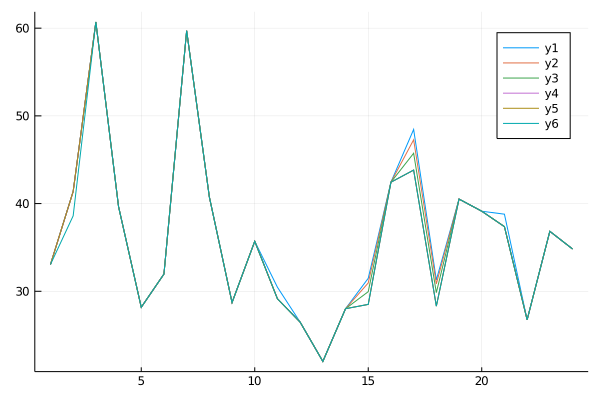

In [442]:
plot(prices_budget)